In [3]:
from pyspark import SparkContext
import pandas as pd
import numpy as np

# For data manipulations using SQL format and functions
from pandasql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit, from_utc_timestamp
from pyspark.sql.functions import count, countDistinct, rank, dense_rank, from_unixtime, unix_timestamp
from pyspark.sql.window import Window

#Importing required libraries for Visualizations and Statistics 
import matplotlib.pyplot as plty
from pyspark.mllib.stat import Statistics
import plotly as plt
import plotly.express as px
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import plotly.offline as py
import plotly.graph_objs as go

#Importing required libraries
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

## Libraries for Modelling 
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
pd.options.display.float_format = '{:.2f}'.format

### Reading the csv data

In [4]:
spark = SparkSession\
        .builder\
        .appName("CovidData")\
        .getOrCreate()

covid_daily_df = spark.read.csv('us-counties.csv', header = 'True',inferSchema='True')

#printing the number of rows and columns of the dataset
print((covid_daily_df.count(), len(covid_daily_df.columns)))
print('\n')
print(covid_daily_df.show(5))

(411727, 8)


+-------+-------+-------+----+-----+------+-----------+------------+
|   date| county|  state|fips|cases|deaths|daily_cases|daily_deaths|
+-------+-------+-------+----+-----+------+-----------+------------+
|3/24/20|Autauga|Alabama|1001|    1|     0|          1|           0|
|3/25/20|Autauga|Alabama|1001|    4|     0|          3|           3|
|3/26/20|Autauga|Alabama|1001|    6|     0|          2|           2|
|3/27/20|Autauga|Alabama|1001|    6|     0|          0|           0|
|3/28/20|Autauga|Alabama|1001|    6|     0|          0|           0|
+-------+-------+-------+----+-----+------+-----------+------------+
only showing top 5 rows

None


In [5]:
covid_daily_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- daily_cases: integer (nullable = true)
 |-- daily_deaths: integer (nullable = true)



+-------+----------+-----------+----------------+-----------------+
|   date|sum(cases)|sum(deaths)|sum(daily_cases)|sum(daily_deaths)|
+-------+----------+-----------+----------------+-----------------+
| 8/7/20|   4950708|     160712|           60979|            60979|
| 8/6/20|   4889740|     159365|           57516|            57516|
| 8/5/20|   4832403|     158306|           53726|            53726|
| 8/4/20|   4778669|     157062|           53295|            53295|
| 8/3/20|   4725274|     155714|           47528|            47528|
| 8/2/20|   4677855|     155106|           49335|            49335|
| 8/1/20|   4628534|     154693|           58135|            58135|
| 7/9/20|   3131754|     132920|           59901|            59901|
| 7/8/20|   3071855|     132079|           59473|            59473|
| 7/7/20|   3012374|     131133|           54175|            54175|
| 7/6/20|   2958207|     130177|           47315|            47315|
| 7/5/20|   2910892|     129786|           44885

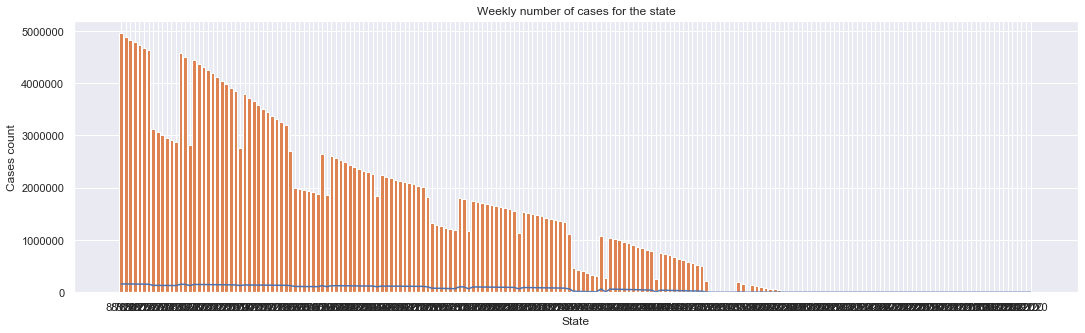

None

In [9]:
state_wise_sum_cases= covid_daily_df.groupBy("date").sum("cases","deaths","daily_cases","daily_deaths").sort(col("date").desc())

state_wise_sum_cases.show()

state_x=state_wise_sum_cases.toPandas()['date'].values.tolist()
state_y=state_wise_sum_cases.toPandas()['sum(cases)'].values.tolist()
state_y1=state_wise_sum_cases.toPandas()['sum(deaths)'].values.tolist()

plt.figure(figsize=(18,5))
plt.bar(state_x,state_y, color = 'C1', align='center')
plt.plot(state_x,state_y1, color = 'C0')
plt.title('Weekly number of cases for the state')
plt.xlabel('State')
plt.ylabel('Cases count', rotation = 90).set_rotation(90)
display(plt.show())

In [12]:
covid_daily_df = covid_daily_df.select("*").toPandas()

In [19]:
state_agg_df = covid_daily_df.groupby(["state"], as_index = False)[["cases", "deaths","daily_cases","daily_deaths"]].sum()
#us_agg_df['date'] = us_agg_df['date'].astype('datetime64[ns]')
#us_agg_df = us_agg_df.sort_values(by = 'date')

In [27]:
fig = px.bar(state_agg_df, x='state', y='daily_cases', color='daily_cases', height=500, width = 1000)
#fig = px.line(us_agg_df, x='date', y='deaths', color='cases', height=500)

fig.update_layout(title='Confirmed Cases in US',
                 xaxis_title="state",
                 yaxis_title="Confirmed Cases")

### Country level Aggregation at date level

In [13]:
us_agg_df = covid_daily_df.groupby(["date"], as_index = False)[["cases", "deaths","daily_cases","daily_deaths"]].sum()
us_agg_df['date'] = us_agg_df['date'].astype('datetime64[ns]')
us_agg_df = us_agg_df.sort_values(by = 'date')

In [17]:
fig = px.bar(us_agg_df, x='date', y='cases', color='cases', height=500)
#fig = px.line(us_agg_df, x='date', y='deaths', color='cases', height=500)

fig.update_layout(title='Confirmed Cases in US',
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

In [7]:
fig = px.bar(us_agg_df, x='date', y='daily_cases', color='cases', height=500)

fig.update_layout(title='Confirmed Cases in US',
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

In [8]:
fig = px.bar(us_agg_df, x='date', y='deaths', color='deaths', height=500)

fig.update_layout(title='Deaths in US',
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

In [9]:
fig = px.bar(us_agg_df, x='date', y='daily_deaths', color='deaths', height=500)

fig.update_layout(title='Deaths in US',
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

### Creating some basic features using date

In [10]:
us_agg_df['quarter'] = us_agg_df['date'].dt.quarter
us_agg_df['month'] = us_agg_df['date'].dt.month
us_agg_df['year'] = us_agg_df['date'].dt.year
us_agg_df['dayofyear'] = us_agg_df['date'].dt.dayofyear
us_agg_df['dayofmonth'] = us_agg_df['date'].dt.day
us_agg_df['weekofyear'] = us_agg_df['date'].dt.weekofyear
us_agg_df["days_since"] = (us_agg_df.index-us_agg_df.index[0])

In [11]:
us_agg_df.set_index('date')

,cases,deaths,daily_cases,daily_deaths,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_since
date,,,,,,,,,,,
2020-01-21,1,0,1,1,1,1,2020,21,21,4,0
2020-01-22,1,0,0,0,1,1,2020,22,22,4,1
2020-01-23,1,0,0,0,1,1,2020,23,23,4,2
2020-01-24,2,0,1,1,1,1,2020,24,24,4,3
2020-01-25,3,0,1,1,1,1,2020,25,25,4,4
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-03,4725274,155714,47528,47528,3,8,2020,216,3,32,195
2020-08-04,4778669,157062,53295,53295,3,8,2020,217,4,32,196
2020-08-05,4832403,158306,53726,53726,3,8,2020,218,5,32,197


In [113]:
us_agg_df.head()

,date,cases,deaths,daily_cases,daily_deaths,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_since
0,2020-01-21,1,0,1,1,1,1,2020,21,21,4,0
1,2020-01-22,1,0,0,0,1,1,2020,22,22,4,1
2,2020-01-23,1,0,0,0,1,1,2020,23,23,4,2
3,2020-01-24,2,0,1,1,1,1,2020,24,24,4,3
4,2020-01-25,3,0,1,1,1,1,2020,25,25,4,4


In [114]:
us_daily_agg_df = us_agg_df

#### For Prophet model we need to define two input columns ds, y - with the exact names.

* renaming date to ds
* renaming cases to y as our predictor variable

In [115]:
us_daily_agg_df['ds'] = us_daily_agg_df['date']
us_daily_agg_df['y'] = us_daily_agg_df['daily_cases']

us_daily_agg_df.head()

,date,cases,deaths,daily_cases,daily_deaths,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_since,ds,y
0,2020-01-21,1,0,1,1,1,1,2020,21,21,4,0,2020-01-21,1
1,2020-01-22,1,0,0,0,1,1,2020,22,22,4,1,2020-01-22,0
2,2020-01-23,1,0,0,0,1,1,2020,23,23,4,2,2020-01-23,0
3,2020-01-24,2,0,1,1,1,1,2020,24,24,4,3,2020-01-24,1
4,2020-01-25,3,0,1,1,1,1,2020,25,25,4,4,2020-01-25,1


In [116]:
model_daily = Prophet(yearly_seasonality=True)

### Fitting prophet model on daily aggregate data

In [117]:
model_daily.fit(us_daily_agg_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Predicting the cases for next 90 days

In [118]:
future_daily = model_daily.make_future_dataframe(periods=60)
forecast_daily = model_daily.predict(future_daily)

In [119]:
print(forecast_daily.head())

          ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-01-21 -4946.14    -6350.48      311.04     -4946.14     -4946.14   
1 2020-01-22 -4650.26    -4322.50     2519.30     -4650.26     -4650.26   
2 2020-01-23 -4354.38    -1663.66     5181.00     -4354.38     -4354.38   
3 2020-01-24 -4058.50      106.10     6621.68     -4058.50     -4058.50   
4 2020-01-25 -3762.62    -2376.21     4192.14     -3762.62     -3762.62   

   additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0         2007.78               2007.78               2007.78 -894.44   
1         3714.25               3714.25               3714.25  315.20   
2         6007.29               6007.29               6007.29 2250.27   
3         7237.35               7237.35               7237.35 3258.73   
4         4658.98               4658.98               4658.98  589.43   

   weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0       -894.44       -894.44 2902.22    

### Plotting forecasted values

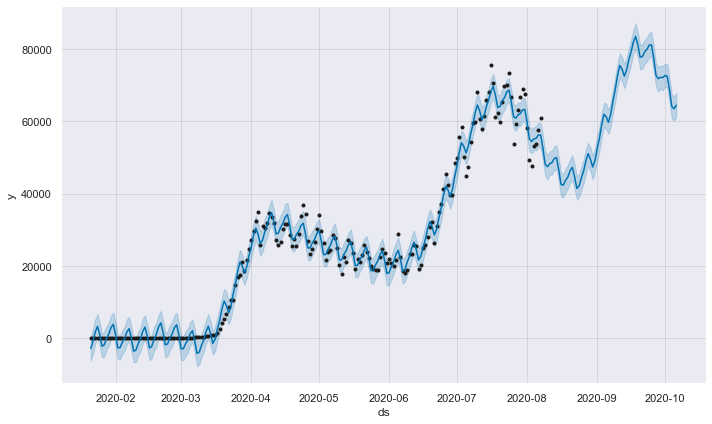

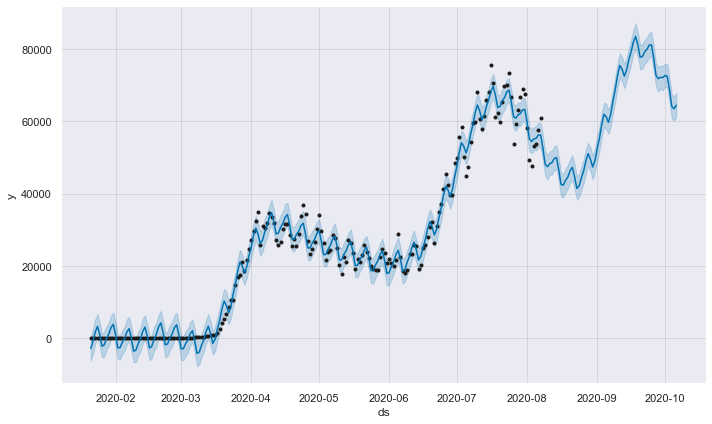

In [120]:
model_daily.plot(forecast_daily)

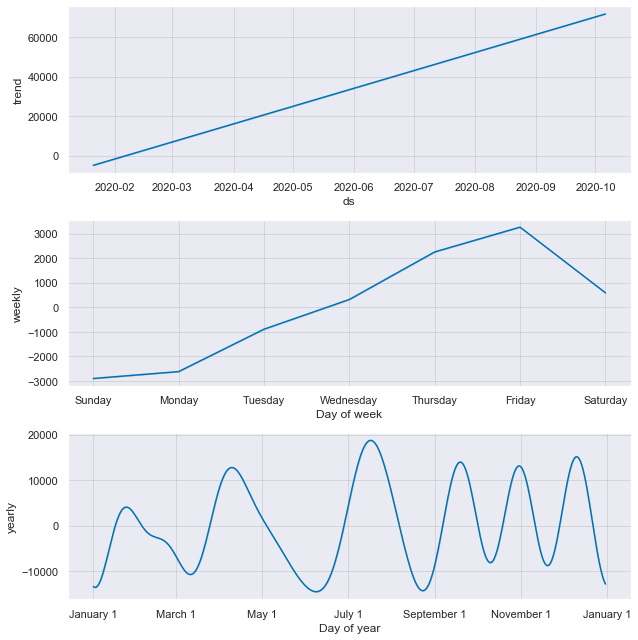

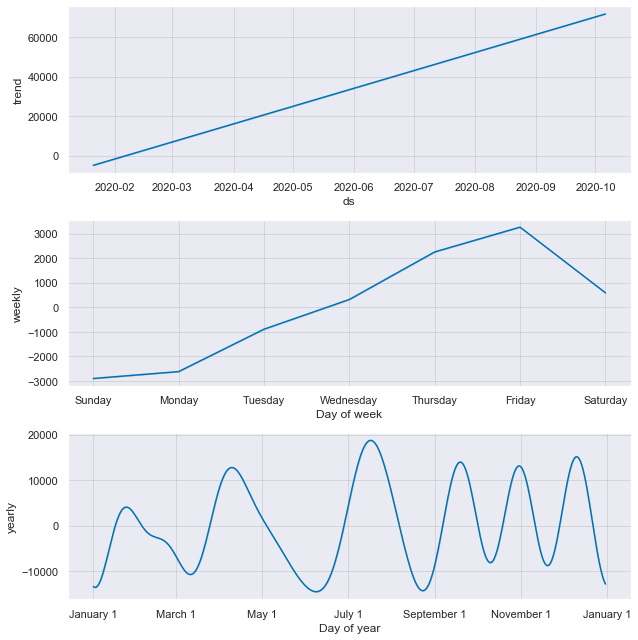

In [121]:
model_daily.plot_components(forecast_daily)

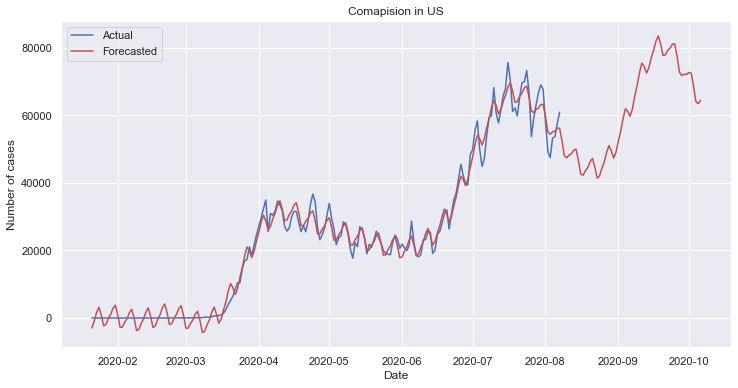

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(us_daily_agg_df['date'], us_daily_agg_df['daily_cases'], 'b-', label = 'Actual')
plt.plot(forecast_daily['ds'], forecast_daily['yhat'], 'r-', label = 'Forecasted')
plt.xlabel('Date'); plt.ylabel('Number of cases'); plt.title('Comapision in US')
plt.legend();

In [38]:
predicted_vs_actual = forecast_daily.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(us_daily_agg_df.set_index('ds')[['y']])

predicted_vs_actual['e'] = predicted_vs_actual['y'] - predicted_vs_actual['yhat']
predicted_vs_actual['p'] = 100 * predicted_vs_actual['e'] / predicted_vs_actual['y']

mean_error = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

predicted_vs_actual.head()


,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2020-01-21,-2938.36,-6087.73,352.86,1.00,2939.36,293936.20
2020-01-22,-936.01,-4387.64,2427.50,1.00,937.01,93700.90
2020-01-23,1652.91,-1842.88,5098.41,1.00,-1651.91,-165190.73
2020-01-24,3178.85,-251.42,6366.64,2.00,-3176.85,-158842.40
2020-01-25,896.36,-2496.95,4127.79,3.00,-893.36,-29778.77


In [39]:
rmse = np.sqrt(np.mean(predicted_vs_actual.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*predicted_vs_actual.e/predicted_vs_actual.y)), 0)

print('RMSE = ', rmse)
print('MAPE =', mape, '%')

RMSE =  1967640.93
MAPE = 6403.0 %


In [41]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

cross_validation_results = cross_validation(model_daily, initial='150 days', period='7 days', horizon='7 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-06-19 00:00:00 and 2020-07-31 00:00:00


In [42]:
df_p = performance_metrics(cross_validation_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,41272187.67,6424.34,5218.85,0.10,0.10,0.29
1,2 days,96641699.70,9830.65,8451.43,0.18,0.17,0.14
2,3 days,110248122.12,10499.91,9222.16,0.18,0.22,0.14
3,4 days,64229813.44,8014.35,7281.76,0.13,0.13,0.14
4,5 days,61486342.81,7841.32,6926.25,0.12,0.12,0.14


In [79]:
states_agg_df = covid_daily_df.groupby(["date","state"], as_index = False)[["cases", "deaths","daily_cases","daily_deaths"]].sum()
states_agg_df = states_agg_df.sort_values(by = 'date')
states_agg_df['date'] = states_agg_df['date'].astype('datetime64[ns]')



In [80]:
states_agg_df.state.unique()

array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'New York',
       'Rhode Island', 'Florida', 'Pennsylvania', 'New Jersey',
       'North Carolina', 'Ohio', 'Oklahoma', 'South Dakota', 'Tennessee',
       'Vermont', 'Virginia', 'New Hampshire', 'South Carolina', 'Nevada',
       'Connecticut', 'Missouri', 'Colorado', 'Georgia', 'Hawaii',
       'District of Columbia', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maryland', 'Michigan', 'Minnesota', 'Indiana', 'North Dakota',
       'New Mexico', 'Wyoming', 'Mississippi', 'Arkansas', 'Delaware',
       'Alaska', 'Maine', 'Puerto Rico', 'Montana', 'Alabama', 'Idaho',
       'Virgin Islands', 'Guam', 'West Virginia',
       'Northern Mariana Islands'], dtype=object)

In [53]:
State = input("Enter State value from the above list: ")
State

Enter State value from the above list: Texas


'Texas'

In [54]:
states_agg_State_df = states_agg_df[(states_agg_df['state'] == State)]
states_agg_State_df = states_agg_State_df.sort_values(by = 'date')

In [55]:
fig = px.bar(states_agg_State_df, x='date', y='cases', color='cases', height=500)

fig.update_layout(title='Confirmed Cases in ' + State,
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

In [56]:
fig = px.bar(states_agg_State_df, x='date', y='daily_cases', color='cases', height=500)

fig.update_layout(title='Confirmed Cases in ' + State,
                 xaxis_title="Date",
                 yaxis_title="Confirmed Cases")

In [57]:
states_agg_State_df['ds'] = states_agg_State_df['date']
states_agg_State_df['y'] = states_agg_State_df['daily_cases']

##us_agg_df = us_agg_df.rename(columns={'date':'ds', 'cases':'y'},inplace=True)
states_agg_State_df.head()

,date,state,cases,deaths,daily_cases,daily_deaths,ds,y
53,2020-02-12,Texas,1,0,1,1,2020-02-12,1
60,2020-02-13,Texas,2,0,1,1,2020-02-13,1
67,2020-02-14,Texas,2,0,0,0,2020-02-14,0
74,2020-02-15,Texas,2,0,0,0,2020-02-15,0
81,2020-02-16,Texas,2,0,0,0,2020-02-16,0


In [65]:
from fbprophet import Prophet

m_state = Prophet(daily_seasonality=True)

In [66]:
states_agg_State_df.head()

,date,state,cases,deaths,daily_cases,daily_deaths,ds,y
53,2020-02-12,Texas,1,0,1,1,2020-02-12,1
60,2020-02-13,Texas,2,0,1,1,2020-02-13,1
67,2020-02-14,Texas,2,0,0,0,2020-02-14,0
74,2020-02-15,Texas,2,0,0,0,2020-02-15,0
81,2020-02-16,Texas,2,0,0,0,2020-02-16,0


In [67]:
m_state.fit(states_agg_State_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [68]:
future = m_state.make_future_dataframe(periods=30)

forecast = m_state.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-12,-82.02,-1568.72,1510.28,-82.02,-82.02,107.58,107.58,107.58,-332.53,-332.53,-332.53,440.11,440.11,440.11,0.00,0.00,0.00,25.56
1,2020-02-13,-63.87,-1603.66,1708.14,-63.87,-63.87,67.18,67.18,67.18,-332.53,-332.53,-332.53,399.71,399.71,399.71,0.00,0.00,0.00,3.31
2,2020-02-14,-45.72,-1844.05,1442.95,-45.72,-45.72,-204.76,-204.76,-204.76,-332.53,-332.53,-332.53,127.77,127.77,127.77,0.00,0.00,0.00,-250.48
3,2020-02-15,-27.57,-2121.43,1002.58,-27.57,-27.57,-566.50,-566.50,-566.50,-332.53,-332.53,-332.53,-233.97,-233.97,-233.97,0.00,0.00,0.00,-594.08
4,2020-02-16,-9.42,-2817.53,389.56,-9.42,-9.42,-1213.91,-1213.91,-1213.91,-332.53,-332.53,-332.53,-881.38,-881.38,-881.38,0.00,0.00,0.00,-1223.33


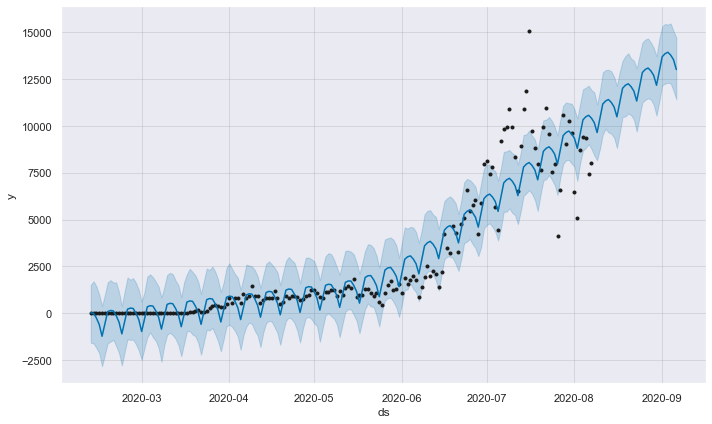

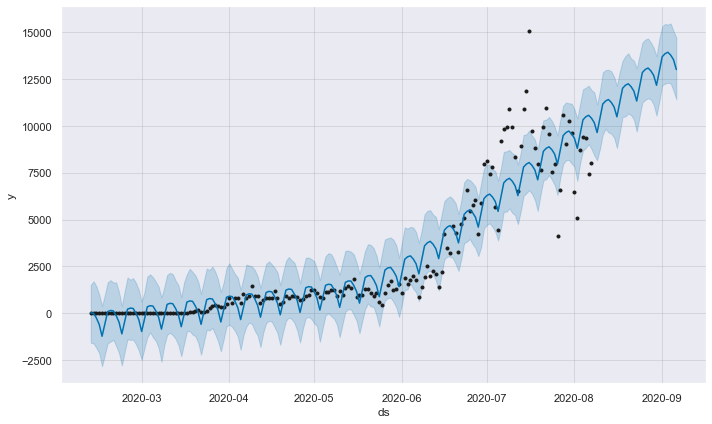

In [69]:
m_state.plot(forecast)

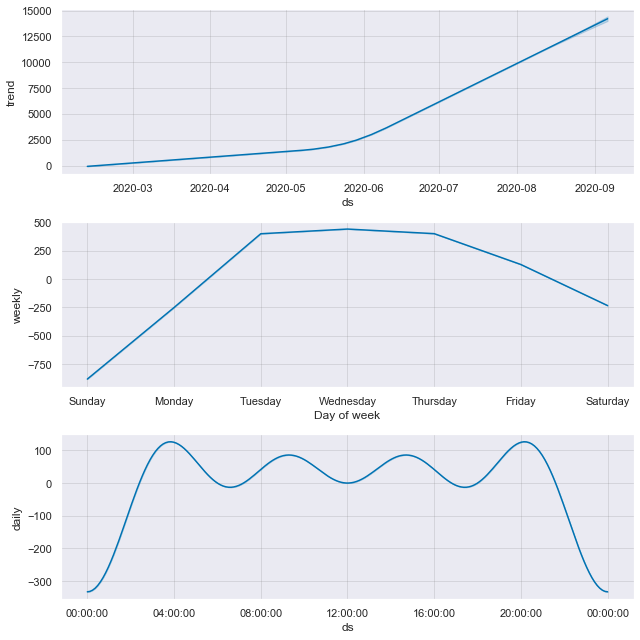

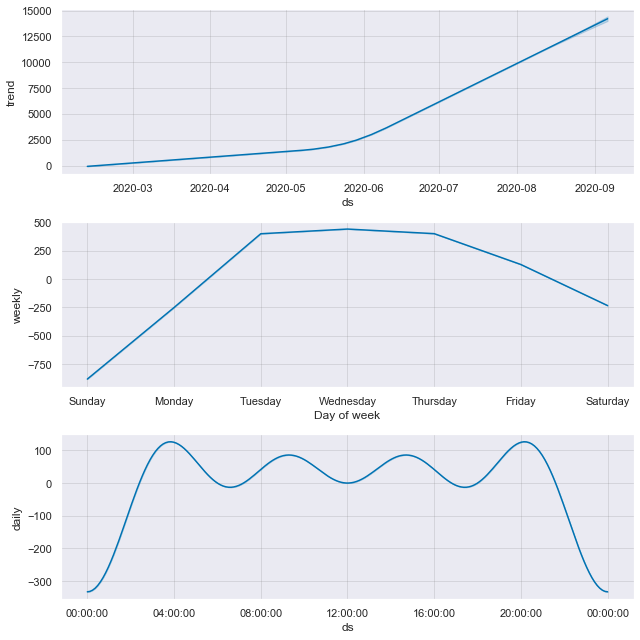

In [70]:
m_state.plot_components(forecast)

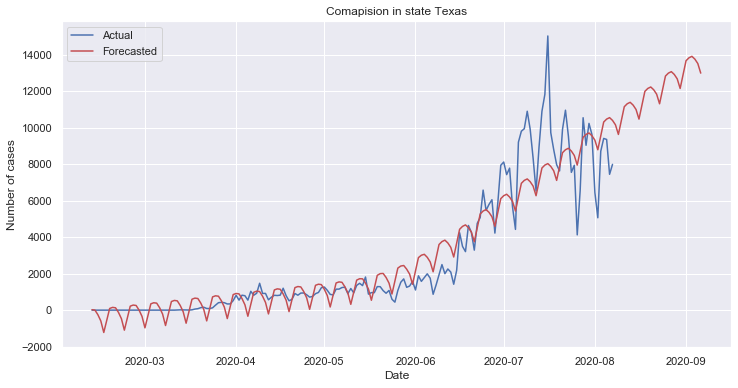

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(states_agg_State_df['date'], states_agg_State_df['daily_cases'], 'b-', label = 'Actual')
plt.plot(forecast['ds'], forecast['yhat'], 'r-', label = 'Forecasted')
plt.xlabel('Date'); plt.ylabel('Number of cases'); plt.title('Comapision in state '+ State)
plt.legend();

In [72]:
predicted_vs_actual = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(states_agg_State_df.set_index('ds')[['y']])

predicted_vs_actual['e'] = predicted_vs_actual['y'] - predicted_vs_actual['yhat']
predicted_vs_actual['p'] = 100 * predicted_vs_actual['e'] / predicted_vs_actual['y']

mean_error = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

predicted_vs_actual.head()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2020-02-12,25.56,-1568.72,1510.28,1.00,-24.56,-2455.70
2020-02-13,3.31,-1603.66,1708.14,1.00,-2.31,-231.04
2020-02-14,-250.48,-1844.05,1442.95,0.00,250.48,inf
2020-02-15,-594.08,-2121.43,1002.58,0.00,594.08,inf
2020-02-16,-1223.33,-2817.53,389.56,0.00,1223.33,inf


In [73]:
rmse = np.sqrt(np.mean(predicted_vs_actual.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*predicted_vs_actual.e/predicted_vs_actual.y)), 0)

print('RMSE = ', rmse)
print('MAPE =', mape, '%')

RMSE =  1242.05
MAPE = inf %


In [75]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

cross_validation_results = cross_validation(m_state, initial='150 days', period='7 days', horizon='7 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-07-17 00:00:00 and 2020-07-31 00:00:00


In [76]:
df_p = performance_metrics(cross_validation_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,9592844.41,3097.23,2966.38,0.41,0.36,0.00
1,2 days,24135162.17,4912.76,4651.18,0.95,0.99,0.00
2,3 days,12505193.46,3536.27,3383.42,0.46,0.47,0.00
3,4 days,3253131.59,1803.64,1761.03,0.18,0.20,0.00
4,5 days,5445766.79,2333.62,2206.69,0.23,0.25,0.00
